In [38]:
# Obtiene los datos de precipitación par la Cuenca del Valle
# de Méxco a partir de CHIRPS y los promedia espacialmente.

import os

import rioxarray

import pandas as pd
import numpy as np
import matplotlib

import geopandas as gpd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Permite ajustar los valores de todas las gráficas
#params = {"ytick.color" : "w",
#          "xtick.color" : "w",
#          "axes.labelcolor" : "w",
#          "axes.edgecolor" : "w",
#          "text.color": "w"}
#plt.rcParams.update(params)

In [39]:
path_nc = "../results/CHIRPS_global_days_p05/cuenca_valle_mexico/"
path_shp = "../data/Cuencas/Regiones_Hidrologicas_Administrativas/"
names = ["cuenca_valle_mexico_chirps-v2.0.days_p05.nc", 
    "cuenca_valle_mexico_chirps-v2.0.2021.days_p05.nc",
    "rha250kgw.shp"]

path_d = "../results/onset/"
path_r = "../results/onset/graficas/"

# Si no existe la carpeta, la crea.
if not os.path.exists(path_r):
    os.mkdir(path_r)

df_pre = pd.read_csv(path_d + "pre_daily_CHIRPS.csv", index_col = "time" )
df_pre.index = pd.to_datetime( df_pre.index )
df_pre = df_pre[ ~ ( (df_pre.index.month == 2) & (df_pre.index.day == 29) ) ]

df = df_pre.resample("M").sum()
df = df.groupby(df.index.month).mean()
tot = df.sum().values[0]

# Precipitación total.
print( f"Total: {tot}" )
# Parciales.
print("Junio, julio, agosto")
print( df[ df.index.isin( [6, 7, 8] ) ].sum().values[0] * 100 / tot )
print("Junio, julio, agosto, septiembre")
print( df[ df.index.isin( [6, 7, 8, 9] ) ].sum().values[0] * 100 / tot )
print("Noviembre, diciembre, enero, febrero")
print( df[ df.index.isin( [11, 12, 1, 2] ) ].sum().values[0] * 100 / tot )

Total: 656.004931373146
Junio, julio, agosto
53.77486072693841
Junio, julio, agosto, septiembre
70.56077026693565
Noviembre, diciembre, enero, febrero
6.512872093644958


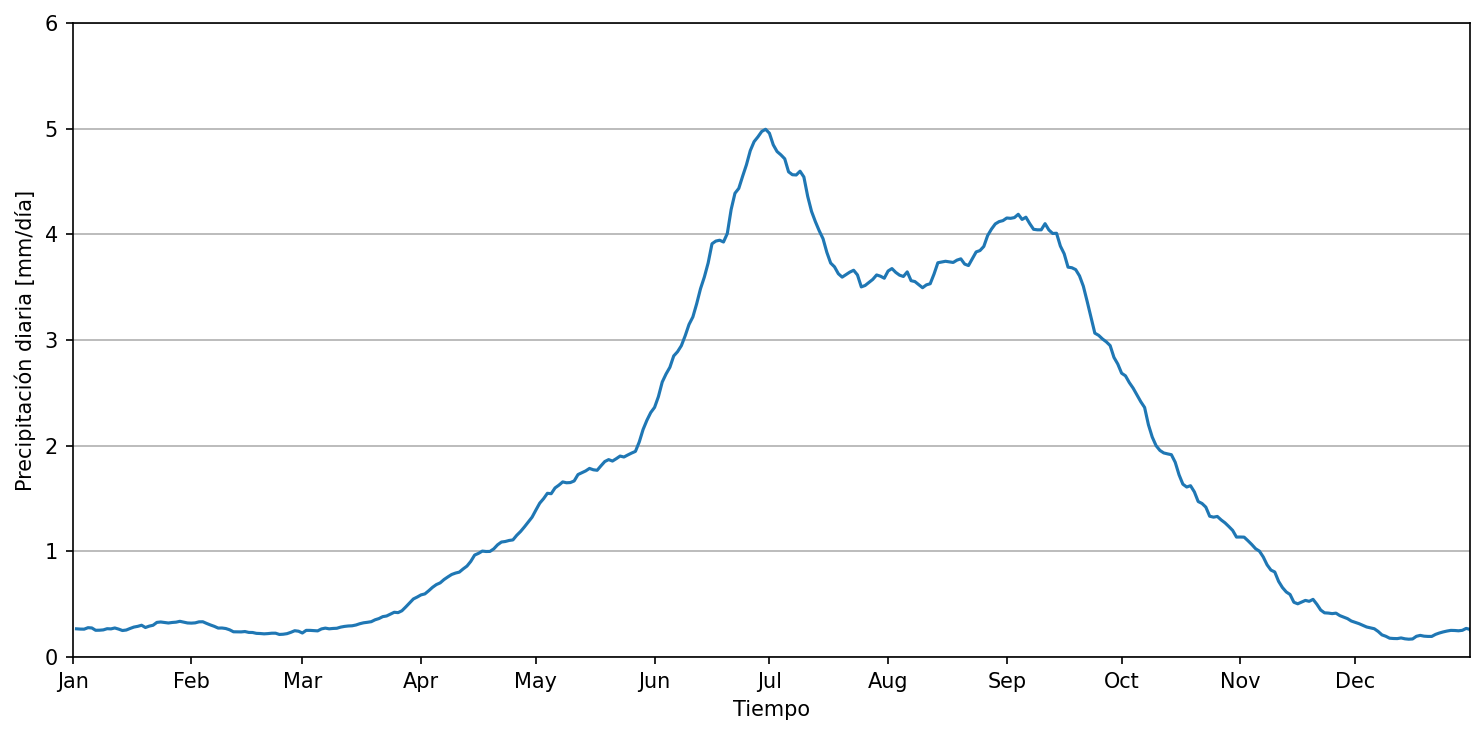

In [40]:
df_mean = df_pre.groupby(df_pre.index.dayofyear).mean()
df_mean.index = ( pd.to_datetime("2000-01-01") 
    + pd.to_timedelta(df_mean.index, "D") )

# Graficamos.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 5)
fig.set_dpi(150)

ax.plot(df_mean)
ax.grid(axis = "y")
ax.set_ylabel("Precipitación diaria [mm/día]")
ax.set_xlabel("Tiempo")
ax.set_ylim(0, 6)
ax.set_xlim( pd.to_datetime("2000-01-01"), pd.to_datetime("2000-12-31") )
# Formato de fecha.
ax.xaxis.set_major_locator( mdates.MonthLocator() )
ax.xaxis.set_major_formatter( mdates.DateFormatter("%b") )

# Separación adecuada entre gráficas.
fig.tight_layout()

fig.savefig( path_r + "pre_mean_cuenca_CHIRPS.png", bbox_inches = "tight" )

In [41]:
date

,Cuenca - Onset,Cuenca - Withdrawal,Cuenca - Length
Año,,,
1981,2000-05-18,2000-11-04,170 days
1982,2000-05-06,2000-10-19,166 days
1983,2000-05-17,2000-09-27,133 days
1984,2000-05-28,2000-09-21,116 days
1985,2000-05-07,2000-10-09,155 days
1986,2000-05-16,2000-10-12,149 days
1987,2000-05-17,2000-10-07,143 days
1988,2000-06-12,2000-09-15,95 days
1989,2000-06-14,2000-09-23,101 days


Onset     : 02 June
Withdrawal: 14 October


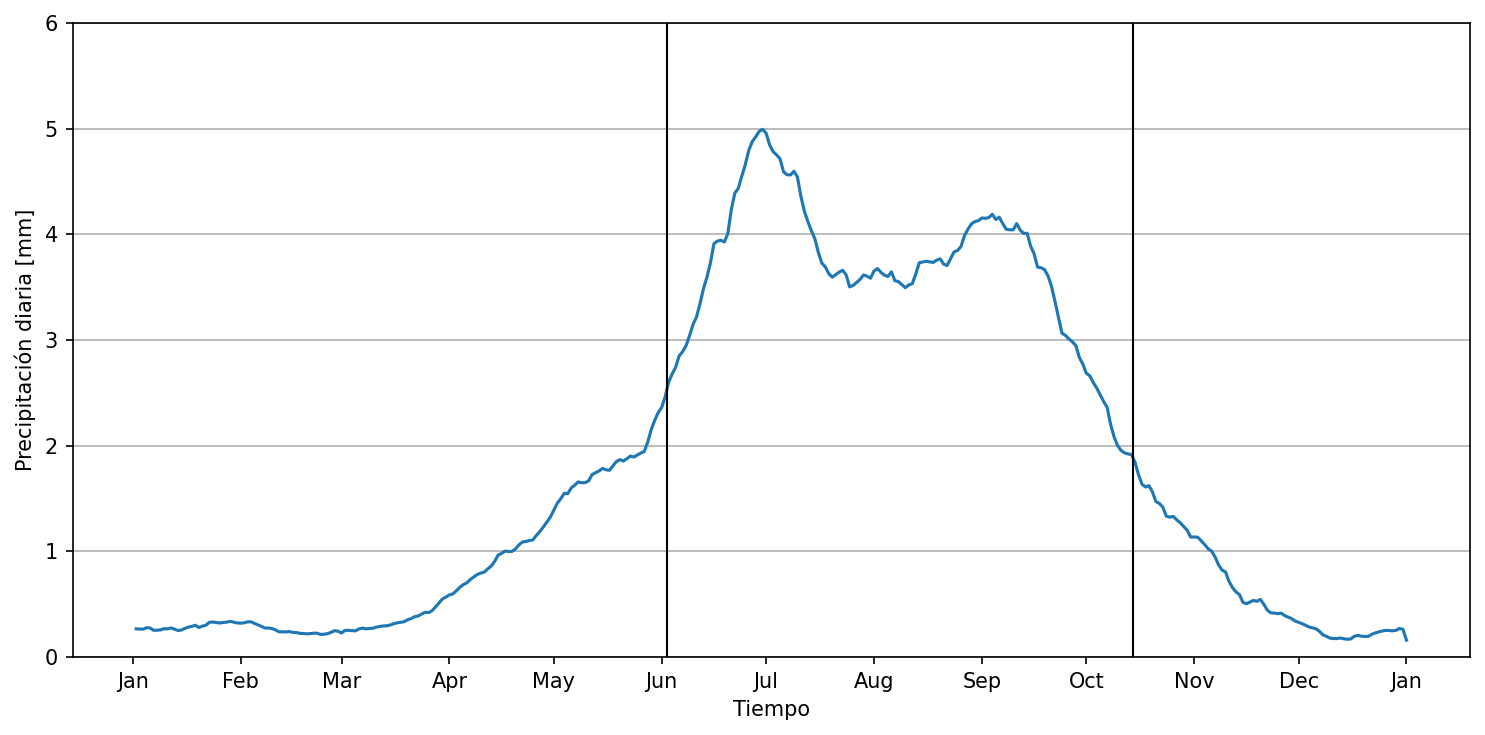

In [42]:
# Cargamos el archivo y ajustamos formatos.
date = pd.read_csv(path_d + "onset_CHIRPS.csv", index_col = "Año" )
date.index = pd.RangeIndex(date.index[0], date.index[-1] + 1, name = "Año" )
date.iloc[:, 0] = pd.to_datetime( date.iloc[:, 0] )
date.iloc[:, 1] = pd.to_datetime( date.iloc[:, 1] )

# Convertimos a día juliano.
date.iloc[:, 0] = date.iloc[:, 0].apply(lambda x: x.dayofyear)
date.iloc[:, 1] = date.iloc[:, 1].apply(lambda x: x.dayofyear)
# Ajustamos los años bisiestos.
date.iloc[date.index % 4 == 0, 0:2] = date.iloc[date.index % 4 == 0, 0:2] - 1

# Reconvertimos a fecha.
date.iloc[:, 0] = ( pd.to_datetime("2000-01-01")
    + pd.to_timedelta(date.iloc[:, 0], "D") )
date.iloc[:, 1] = ( pd.to_datetime("2000-01-01")
    + pd.to_timedelta(date.iloc[:, 1], "D") )

# Fechas.
onset = date.iloc[:, 0].mean()
withdrawal = date.iloc[:, 1].mean()

print( f"Onset     : {onset.day:02d}" + f" {onset.month_name()}" )
print( f"Withdrawal: {withdrawal.day:02d}" + f" {withdrawal.month_name()}" )

# Graficamos.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 5)
fig.set_dpi(150)

# Curva suavizada.
ax.plot(df_mean)

# Onset y withdrawal.
ax.plot( (onset, onset), (0, 6), color = "k", linewidth = 1 )
ax.plot( (withdrawal, withdrawal), (0, 6), color = "k", linewidth = 1 )

ax.grid(axis = "y")
ax.set_ylabel("Precipitación diaria [mm]")
ax.set_xlabel("Tiempo")
ax.set_ylim(0, 6)
#ax.set_xlim( pd.to_datetime("1995-01-01"),
#    pd.to_datetime("1995-12-31") )
ax.set_title("")
# Formato de fecha.
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

# Separación adecuada entre gráficas.
fig.tight_layout()

fig.savefig(path_r + "pre_ind_cuenca_CHIRPS.png", bbox_inches = "tight")
